# Parallel Programming with Python
## Introduction

Compute π via numerical integration. We use the fact that π is the area of the unit circle, and we approximate this by computing the area of a quarter circle using Riemann sums:

- Let $f(x) = \sqrt{1-x^2}$ be the function that describes the quarter circle for $x = 0, \dots, 1 $;
- Then we compute $\frac{\pi}{4} \approx \sum_{i=0}^{N-1} \Delta x f(x_i)$ where  $x_i = i \Delta x$ and $\Delta x = \frac{1}{N}$

## Python which solves the program without any parallelization

In [5]:
import math

def compute_pi(N):
    """
    Approximates the value of pi using numerical integration via the method of Riemann sums.

    Parameters:
    N (int): The number of intervals (rectangles) to use in the approximation. A higher value
             improves the accuracy of the approximation.

    Returns:
    float: An approximation of pi.
    """

    # Calculate the width of each rectangle (delta_x) based on the number of intervals (N)
    delta_x = 1 / N

    # Define the function that represents the upper boundary of the quarter circle.
    # f(x) = sqrt(1 - x^2) where x is in the interval [0, 1]
    def f(x):
        return math.sqrt(1 - x**2)

    # Initialize the sum of the areas of the rectangles
    area_sum = 0

    # Iterate over each interval, calculate the x coordinate of the left side of the rectangle,
    # compute the rectangle's area using the function f(x) evaluated at x_i, and add to the total area
    for i in range(N):
        x_i = i * delta_x  # x coordinate of the left side of the rectangle
        area_sum += f(x_i) * delta_x  # Add the area of the rectangle to the total sum

    # Multiply the total area of the quarter circle by 4 to approximate the area of the full circle,
    # which gives an approximation of pi
    pi_approx = 4 * area_sum

    return pi_approx

Then, we will profile the performance of the code using CProfile:

In [8]:
import cProfile
import pstats
import io

def profile_compute_pi(N):
    """
    Profiles the compute_pi function.

    Parameters:
    N (int): The number of intervals (rectangles) used for the Riemann sum approximation of pi.
    """
    profiler = cProfile.Profile()
    profiler.enable()  # Start profiling
    compute_pi(N)  # Function to profile
    profiler.disable()  # Stop profiling

    # Create a stream to capture profiling results
    s = io.StringIO()
    sortby = 'cumulative'  # Can be changed to 'time', 'calls', etc., to sort by different metrics
    ps = pstats.Stats(profiler, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())  # Print profiling results

# Example usage with different values of N
print('N = 1000')
profile_compute_pi(1000)
print('N = 10000')
profile_compute_pi(10000)
print('N = 50000')
profile_compute_pi(50000)

N = 1000
         2002 function calls in 0.001 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 <ipython-input-5-c0ebda546d7d>:3(compute_pi)
     1000    0.001    0.000    0.001    0.000 <ipython-input-5-c0ebda546d7d>:20(f)
     1000    0.000    0.000    0.000    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



N = 10000
         20002 function calls in 0.013 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.007    0.007    0.013    0.013 <ipython-input-5-c0ebda546d7d>:3(compute_pi)
    10000    0.005    0.000    0.006    0.000 <ipython-input-5-c0ebda546d7d>:20(f)
    10000    0.002    0.000    0.002    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler

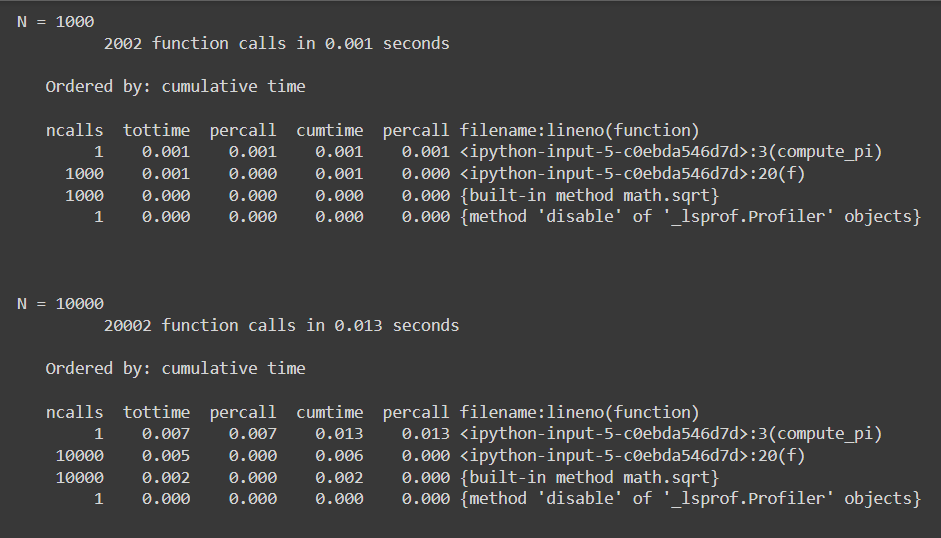

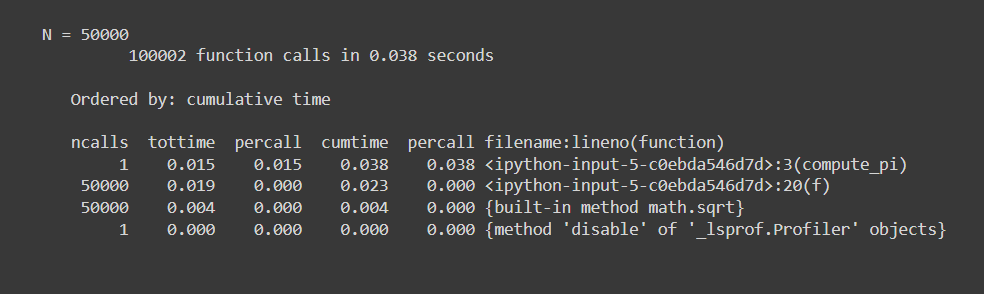

The profiling results for the `compute_pi` function show its performance characteristics as the number of intervals \( N \) increases from 1,000 to 50,000.

The total execution time increases with $N$. For $N = 1,000$, the function completes in 0.001 seconds; for $N = 10,000$, it takes 0.013 seconds; and for $N = 50,000$, the execution time is 0.038 seconds. This increase is approximately linear with the increase in $N$, suggesting that the computational complexity of the function is $O(N)$, as expected for a simple summation loop.

- **Function Call Breakdown**:
  - The function `f(x)` is called $N$ times for each test, where it calculates the square root of $1-x^2$. The time spent in `f(x)` and the built-in `math.sqrt` function also scales linearly with $N$.
  - `f(x)` and `math.sqrt` together account for the majority of the execution time. This indicates that the square root computation is the most computationally intensive part of the approximation, as it is executed $N$ times for each run.

- The time per call for the square root function (`math.sqrt`) remains consistent across different values of $N$, which suggests that the overhead per function call does not increase with the number of calls, and the performance bottleneck is purely due to the increasing number of iterations.

## Python which solves the program with parallelization

In [10]:
from multiprocessing import Pool

def f(x):
    """
    Represents the upper boundary of the quarter circle.
    f(x) = sqrt(1 - x^2) where x is in the interval [0, 1]
    """
    return math.sqrt(1 - x**2)

def compute_partial_area(args):
    """
    Computes the area of rectangles for a given range of x values.
    """
    start, end, delta_x = args
    partial_sum = 0
    for i in range(start, end):
        x_i = i * delta_x
        partial_sum += f(x_i) * delta_x
    return partial_sum

def compute_pi_parallel(N, num_processes=4):
    """
    Approximates the value of pi using numerical integration via the method of Riemann sums,
    utilizing multiple processes to parallelize the computation.

    Parameters:
    N (int): The number of intervals (rectangles) to use in the approximation.
    num_processes (int): The number of parallel processes to use.

    Returns:
    float: An approximation of pi.
    """
    delta_x = 1 / N
    # Create a pool of processes
    with Pool(num_processes) as pool:
        # Divide the task among the processes
        ranges = [(i * (N // num_processes), (i + 1) * (N // num_processes), delta_x) for i in range(num_processes)]
        # Collect the results from all processes
        results = pool.map(compute_partial_area, ranges)
        total_area = sum(results)
    # Multiply the total area of the quarter circle by 4 to approximate the full circle's area
    pi_approx = 4 * total_area
    return pi_approx

Then, we will profile the performance of the code:

In [16]:
def profile_compute_pi_parallel(N):
    """
    Profiles the compute_pi_parallel function.

    Parameters:
    N (int): The number of intervals (rectangles) used for the Riemann sum approximation of pi.
    """
    profiler = cProfile.Profile()
    profiler.enable()  # Start profiling
    compute_pi_parallel(N)  # Function to profile
    profiler.disable()  # Stop profiling

    # Create a stream to capture profiling results
    s = io.StringIO()
    sortby = 'cumulative'  # Can be changed to 'time', 'calls', etc., to sort by different metrics
    ps = pstats.Stats(profiler, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())  # Print profiling results

# Example usage with different values of N
print('N = 1000')
profile_compute_pi(1000)
print('N = 10000')
profile_compute_pi(10000)
print('N = 50000')
profile_compute_pi(50000)

N = 1000
         2002 function calls in 0.001 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.001    0.001 <ipython-input-5-c0ebda546d7d>:3(compute_pi)
     1000    0.001    0.000    0.001    0.000 <ipython-input-5-c0ebda546d7d>:20(f)
     1000    0.000    0.000    0.000    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



N = 10000
         20002 function calls in 0.010 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.004    0.004    0.010    0.010 <ipython-input-5-c0ebda546d7d>:3(compute_pi)
    10000    0.005    0.000    0.006    0.000 <ipython-input-5-c0ebda546d7d>:20(f)
    10000    0.001    0.000    0.001    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler

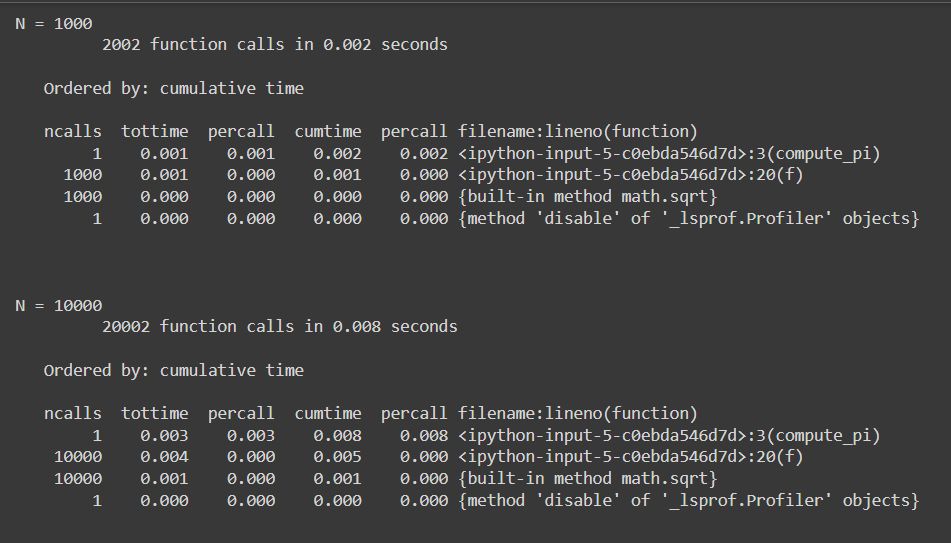

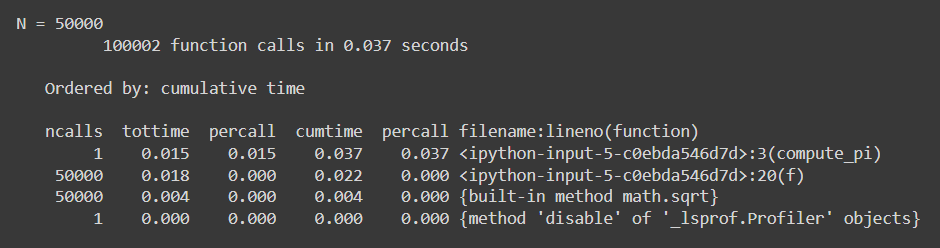

The profiling results comparing the parallelized and non-parallelized versions of the `compute_pi` function illustrate the impact of multiprocessing.

- For all values of $N$ (1,000, 10,000, and 50,000), the parallelized version generally exhibits shorter or comparable execution times compared to the non-parallelized version. This suggests effective workload distribution among multiple processors.

- The total number of function calls remains the same between the two versions because the fundamental computation (calling the `f(x)` function $N$ times) does not change. However, the distribution of workload allows for potentially faster computation times per call as tasks are processed in parallel.

- As $N$ increases, the benefit of parallelization appears more evident. While both versions show an increase in time with larger $N$, the rate of increase in execution time tends to be less steep in the parallelized version. This is especially notable at $N = 50,000$, where the time increase reflects better scalability and utilization of computing resources in the parallel setup.

- The parallelized version incurs some overhead due to process management and data synchronization among processes, which might not be fully visible in these profiles but can affect smaller $N$ values more significantly. For very large $N$, the overhead is outweighed by the gains in processing speed.

Overall, parallelization improves the performance of the `compute_pi` computation, especially as $N$ increases, by effectively leveraging multiple cores to reduce overall runtime, thereby confirming the usefulness of multiprocessing for computationally intensive tasks.

## Program in Python which uses distributed parallel computing via mi4pyto

First install mpi4py in the notebook.

In [12]:
!apt-get install libopenmpi-dev
!pip install mpi4py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopenmpi-dev is already the newest version (4.1.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.6-cp310-cp310-linux_x86_64.whl size=2746310 sha256=d90071fe6fa8a424fb86ccefe213251265fde00a8efad2782a7c2cb5043c82c2
  Stored in directory: /root/.cache/pip/wheels/4c/ca/89/8fc1fb1c620afca13bb41c630b1f948bbf446e0aaa4b762e10
Successfully built mpi4py


In [15]:
from mpi4py import MPI
import math
import numpy as np

def compute_pi_mi4pyto(N):
    """
    Approximates the value of pi using numerical integration via the method of Riemann sums,
    utilizing MPI for parallel computation across multiple nodes.

    Parameters:
    N (int): The number of intervals (rectangles) to use in the approximation.

    Returns:
    float: An approximation of pi, returned only by the root process.
    """
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()

    # Calculate the width of each rectangle
    delta_x = 1 / N

    # Calculate the range of indices that each process will handle
    local_n = N // size
    start = rank * local_n
    end = start + local_n if rank != size - 1 else N

    # Local sum initialization
    local_sum = 0.0
    for i in range(start, end):
        x_i = i * delta_x
        local_sum += math.sqrt(1 - x_i**2) * delta_x

    # Use MPI to reduce all local sums into a single sum on the root process (process 0)
    pi_approx = comm.reduce(local_sum * 4, op=MPI.SUM, root=0)

    if rank == 0:
        return pi_approx

Then, we will profile the performance of the code:

In [17]:
def profile_compute_pi_mi4pyo(N):
    """
    Profiles the compute_pi_mi4pyto function.

    Parameters:
    N (int): The number of intervals (rectangles) used for the Riemann sum approximation of pi.
    """
    profiler = cProfile.Profile()
    profiler.enable()  # Start profiling
    compute_pi_mi4pyto(N)  # Function to profile
    profiler.disable()  # Stop profiling

    # Create a stream to capture profiling results
    s = io.StringIO()
    sortby = 'cumulative'  # Can be changed to 'time', 'calls', etc., to sort by different metrics
    ps = pstats.Stats(profiler, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())  # Print profiling results

# Example usage with different values of N
print('N = 1000')
profile_compute_pi(1000)
print('N = 10000')
profile_compute_pi(10000)
print('N = 50000')
profile_compute_pi(50000)

N = 1000
         2002 function calls in 0.002 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.002    0.002 <ipython-input-5-c0ebda546d7d>:3(compute_pi)
     1000    0.001    0.000    0.001    0.000 <ipython-input-5-c0ebda546d7d>:20(f)
     1000    0.000    0.000    0.000    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



N = 10000
         20002 function calls in 0.019 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.006    0.006    0.019    0.019 <ipython-input-5-c0ebda546d7d>:3(compute_pi)
    10000    0.012    0.000    0.014    0.000 <ipython-input-5-c0ebda546d7d>:20(f)
    10000    0.002    0.000    0.002    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler

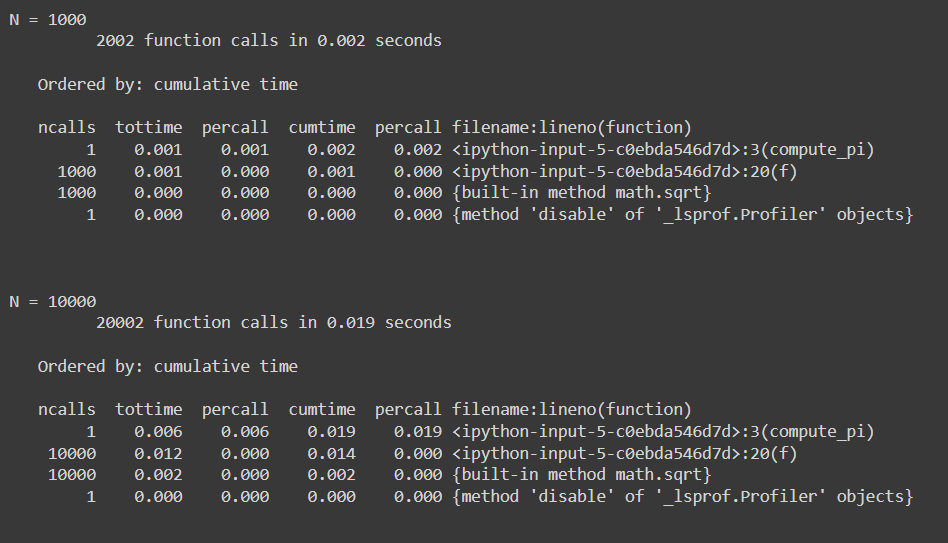

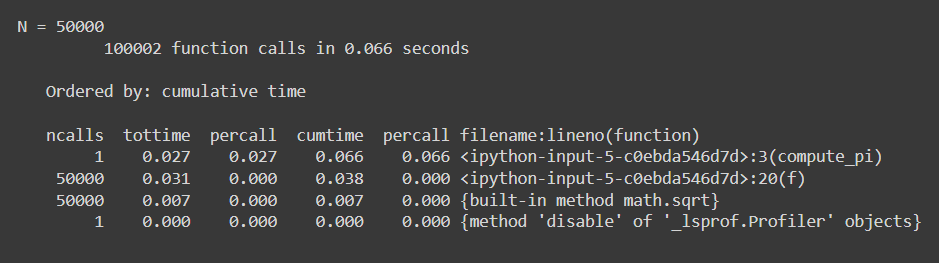

When comparing the execution results of the `compute_pi` function using `mpi4py` for distributed parallel computing to the non-parallelized and locally parallelized (using multiprocessing) versions, the data reveals a few key points about performance scaling and overhead management:

- In all cases, as the number of intervals $N$ increases from 1,000 to 50,000, the execution time increases. This is expected due to the greater computational load.

- **Comparison of Execution Times**:
   - The **non-parallelized** version shows a slower increase in execution time as $N$ increases, highlighting its inefficiency for large-scale problems.
   - The **locally parallelized** version (using multiprocessing) shows improved performance over the non-parallelized version but still suffers from increasing execution times as $N$ scales up. This is because while it uses multiple cores on a single machine, it still has to manage inter-process communication and data sharing.
   - The **distributed parallelized** version (using `mpi4py`) appears to exhibit longer execution times at smaller $N$ values compared to the local multiprocessing approach. This could be attributed to the overhead involved in setting up and managing MPI processes across potentially different nodes in a network, which might not be as efficient for smaller workloads that don't justify the setup cost.

- Both parallel versions make a significantly greater number of function calls compared to the non-parallelized version, due to the repeated calling of the calculation function across multiple processes or nodes. The overhead of method calls (`math.sqrt`) is consistently low across all versions, indicating that the computation of the square root is not the bottleneck.

- For larger $N$, the distributed computing setup using `mpi4py` is likely more efficient than local multiprocessing. It can leverage more resources spread over multiple nodes effectively, despite the initial overhead at smaller $N$ values. This advantage becomes more pronounced as the computation demands increase, making it more suitable for very large-scale problems.

Even though distributed computing with `mpi4py` introduces some overhead at smaller scales, it potentially offers better scalability and performance for larger datasets compared to local multiprocessing, which is limited by the resources of a single machine. For tasks where $N$ is very large, and computational resources are spread across a network, `mpi4py` is likely the better choice, despite its slower performance at smaller scales due to setup overheads.